<b> Question 1 </b>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('Shopify.csv')

df.head()

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
0,1,53,746,224,2,cash,2017-03-13 12:36:56
1,2,92,925,90,1,cash,2017-03-03 17:38:52
2,3,44,861,144,1,cash,2017-03-14 4:23:56
3,4,18,935,156,1,credit_card,2017-03-26 12:43:37
4,5,18,883,156,1,credit_card,2017-03-01 4:35:11


In [ ]:
df.describe()

,order_id,shop_id,user_id,order_amount,total_items
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000
mean,2500.500000,50.078800,849.092400,3145.128000,8.78720
std,1443.520003,29.006118,87.798982,41282.539349,116.32032
min,1.000000,1.000000,607.000000,90.000000,1.00000
25%,1250.750000,24.000000,775.000000,163.000000,1.00000
50%,2500.500000,50.000000,849.000000,284.000000,2.00000
75%,3750.250000,75.000000,925.000000,390.000000,3.00000
max,5000.000000,100.000000,999.000000,704000.000000,2000.00000


We see that the naive calculation of the average order value (AOV) which is equal to $3145.13 comes from the mean of the order amount calculated as shown below.

In [ ]:
naiveAOV = df['order_amount'].sum() / len(df)
print(f"The naive AOV is ${naiveAOV:.2f}")

The naive AOV is $3145.13


On Shopify, we have exactly 100 sneaker shops, and each of these shops sells only one model of shoe. When we want to do an analysis of the AOV, a calculation like this makes no sense since this average order amount just considers the total order amount sum divided by the number of rows in the dataset. This isn't a good enough metric, instead we want to take ito account the total order amount sum divided by the total number of items sold.

In [ ]:
totalAOV = df['order_amount'].sum() / df['total_items'].sum()
print(f"The total AOV is ${totalAOV:.2f}")

The total AOV is $357.92


This total AOV makes more sense but the mean is still not the best way to do the AOV analysis. This is because of the presence of outliers in the data that skew the mean. These outliers can be seen in the boxplot below.

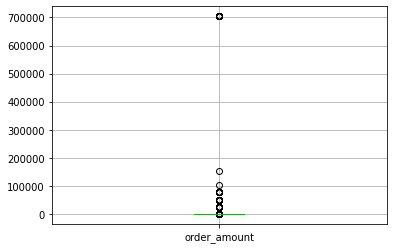

In [ ]:
df.boxplot('order_amount')

We can see from the initial df.describe() result that the standard deviation of the data is 41282.54. This is very high and it means that the values in our dataset vary by 41282.54 from the mean value on average. Therefore, the mean is clearly not a very useful metric to use in this scenario. We can also see the min, 25\%, 50\%, 75\%, and max values from the df.describe() method. A min value of 90 and a max value of 704000 tells us how widely this data is distributed. This max value is much higher than even the 75\% value which means the outliers shown above are increasing the value of mean. A better way to evaluate this data would be the median.

We are going to use the interquartile range (IQR) to spot outliers and calculate the median. The IQR is the range of values between the first and third quartiles, i.e., 25th and 75th percentiles, so it will include the majority of the data points in the dataset. We are going to use 1.5*IQR because of the 68-95-99 rule which is an important characteristic of the normal distribution. Therefore, a data point is an outlier if it falls outside of the range [quartile_1 - 1.5*IQR, quartile_3 + 1.5*IQR] In our dataset, we have several data points that fall out of this range that are outliers. Plotting values within 1.5*IQR of the second quartile gives us a good representation of the data around the median.

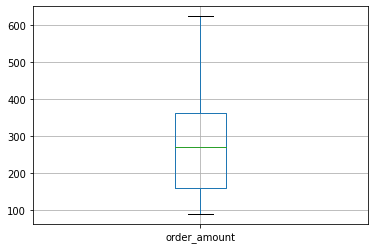

In [ ]:
quartile_1 = df.order_amount.quantile(0.25)
quartile_2 = df.order_amount.quantile(0.50)
quartile_3 = df.order_amount.quantile(0.75)
iqr = quartile_3 - quartile_1

df_median = df[(df.order_amount > quartile_2 - 1.5*iqr) & (df.order_amount < quartile_2 + 1.5*iqr)]
df_median.boxplot(column='order_amount')

In [ ]:
median = df_median['order_amount'].median()
print(median)

272.0


In [ ]:
df_median.describe()

,order_id,shop_id,user_id,order_amount,total_items
count,4738.000000,4738.000000,4738.000000,4738.000000,4738.00000
mean,2500.866399,49.770367,850.325876,283.814268,1.89848
std,1444.266056,29.149727,86.802461,132.061996,0.86278
min,1.000000,1.000000,700.000000,90.000000,1.00000
25%,1247.250000,24.000000,776.000000,161.000000,1.00000
50%,2502.500000,50.000000,851.000000,272.000000,2.00000
75%,3755.750000,74.000000,926.000000,362.000000,2.00000
max,5000.000000,100.000000,999.000000,624.000000,5.00000


Therefore, df_median is a much better representation of the data since the effect of outliers is much lower here as shown in the second boxplot compared to the first boxplot which shows the effect of outliers on the mean. From the df_median.describe() method, we can see that a standard deviation of 132.06 for this data is also much more accurate. Hence, I would report df_median as the metric and this has a median value of 272.

Another way to analyze the data is to look at how the order_amounts vary over the 30 day period. We can find which days have the highest order amounts and are the most busy. We can also see that the sneaker shop sales are low at the beginnning of the month but they increase as the month progresses only to decrease again. This is shown in a line plot below.

In [ ]:
df['created_at'] = pd.to_datetime(df.created_at)
res = df.set_index('created_at').groupby(pd.Grouper(freq='W'))['order_amount'].sum().reset_index()
res.sort_values(by='order_amount', ascending=False).head()

,created_at,order_amount
3,2017-03-26,3629437
1,2017-03-12,3429845
2,2017-03-19,3268887
0,2017-03-05,2724789
4,2017-04-02,2672682


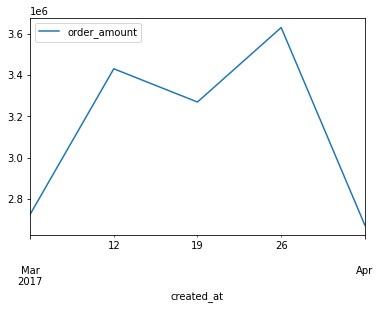

In [ ]:
df['created_at'] = df['created_at'].dt.date
res.plot(x='created_at', y='order_amount', kind='line')

Another way to analyze this data is by shop_id to see which sneaker shop has the highest AOV. The analysis shows that sneaker shop 78 has the highest AOV of $25725.

In [ ]:
shopAOV = df.groupby('shop_id')[['order_amount', 'total_items']].sum()
shopAOV['shop_aov'] = shopAOV['order_amount'] / shopAOV['total_items']
shopAOV.sort_values(by='shop_aov', ascending=False).head()

,order_amount,total_items,shop_aov
shop_id,,,
78,2263800,88,25725.0
42,11990176,34063,352.0
12,18693,93,201.0
89,23128,118,196.0
99,18330,94,195.0


Another way to analyze this data is by user_id to see which customer has the highest AOV for purchases. The analysis shows that user 878 has the highest AOV for purchases ($6539).

In [ ]:
userAOV = df.groupby('user_id')[['order_amount', 'total_items']].sum()
userAOV['user_AOV'] = userAOV['order_amount'] / userAOV['total_items']
userAOV.sort_values(by='user_AOV', ascending=False).head()

,order_amount,total_items,user_AOV
user_id,,,
878,156936,24,6539.000000
766,80076,23,3481.565217
962,80408,24,3350.333333
855,80915,27,2996.851852
775,81114,28,2896.928571


<b> Question 2 </b>

There were 54 orders shipped by Speedy Express in total.

The last name of the employee with the most orders is Peacock with 40 orders.

The product ordered the most by customers in Germany was Boston Crab Meat with 160 orders.